# Findings
The inverse Mills ratio (IMR) coefficient in the selection-corrected logistic regression was not statistically significant, indicating little evidence of selection bias in the field goal attempt data. This suggests that the variables included adequately capture the factors influencing both the decision to attempt and the success of field goals. Therefore, I will exclude the IMR from my Bayesian model, as correcting for selection bias appears unnecessary.

# i. Data Imports

In [80]:
import re
from pathlib import Path

import pandas as pd
import numpy as np
import nfl_data_py as nfl
import statsmodels.api as sm
from scipy.stats import norm

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [45]:
YEARS = range(2010, 2025)

In [46]:
data_root = Path('../data/raw/pbp')
data_root.mkdir(parents=True, exist_ok=True)

def load_or_cache_pbp_data(year):
    cache_file = data_root / f"{year}.parquet"
    
    if cache_file.exists():
        print(f"Loading {year} data from cache...")
        return pd.read_parquet(cache_file)
    else:
        print(f"Downloading {year} data from NFL API...")
        df = nfl.import_pbp_data([year])
        
        # Cache the data
        df.to_parquet(cache_file, index=False)
        print(f"Cached {year} data to {cache_file}")
        
        return df

def load_all_pbp_data(years):
    dataframes = []
    
    for year in years:
        df = load_or_cache_pbp_data(year)
        dataframes.append(df)
    
    print(f"Combining data for {len(dataframes)} seasons...")
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Total rows: {len(combined_df):,}")
    
    return combined_df

In [47]:
pbp_data = load_all_pbp_data(YEARS)
pbp_data.head()

Loading 2010 data from cache...
Loading 2011 data from cache...
Loading 2012 data from cache...
Loading 2013 data from cache...
Loading 2014 data from cache...
Loading 2015 data from cache...
Loading 2016 data from cache...
Loading 2017 data from cache...
Loading 2018 data from cache...
Loading 2019 data from cache...
Loading 2020 data from cache...
Loading 2021 data from cache...
Loading 2022 data from cache...
Loading 2023 data from cache...
Loading 2024 data from cache...
Combining data for 15 seasons...
Total rows: 721,564


,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,quarter_seconds_remaining,half_seconds_remaining,game_seconds_remaining,game_half,quarter_end,drive,sp,qtr,down,goal_to_go,time,yrdln,ydstogo,ydsnet,desc,play_type,yards_gained,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,pass_length,pass_location,air_yards,yards_after_catch,run_location,run_gap,field_goal_result,kick_distance,extra_point_result,two_point_conv_result,home_timeouts_remaining,away_timeouts_remaining,timeout,timeout_team,td_team,td_player_name,td_player_id,posteam_timeouts_remaining,defteam_timeouts_remaining,total_home_score,total_away_score,posteam_score,defteam_score,score_differential,posteam_score_post,defteam_score_post,score_differential_post,no_score_prob,opp_fg_prob,opp_safety_prob,opp_td_prob,fg_prob,safety_prob,td_prob,extra_point_prob,two_point_conversion_prob,ep,epa,total_home_epa,total_away_epa,total_home_rush_epa,total_away_rush_epa,total_home_pass_epa,total_away_pass_epa,air_epa,yac_epa,comp_air_epa,comp_yac_epa,total_home_comp_air_epa,total_away_comp_air_epa,total_home_comp_yac_epa,total_away_comp_yac_epa,total_home_raw_air_epa,total_away_raw_air_epa,total_home_raw_yac_epa,total_away_raw_yac_epa,wp,def_wp,home_wp,away_wp,wpa,vegas_wpa,vegas_home_wpa,home_wp_post,away_wp_post,vegas_wp,vegas_home_wp,total_home_rush_wpa,total_away_rush_wpa,total_home_pass_wpa,total_away_pass_wpa,air_wpa,yac_wpa,comp_air_wpa,comp_yac_wpa,total_home_comp_air_wpa,total_away_comp_air_wpa,total_home_comp_yac_wpa,total_away_comp_yac_wpa,total_home_raw_air_wpa,total_away_raw_air_wpa,total_home_raw_yac_wpa,total_away_raw_yac_wpa,punt_blocked,first_down_rush,first_down_pass,first_down_penalty,third_down_converted,third_down_failed,fourth_down_converted,fourth_down_failed,incomplete_pass,touchback,interception,punt_inside_twenty,punt_in_endzone,punt_out_of_bounds,punt_downed,punt_fair_catch,kickoff_inside_twenty,kickoff_in_endzone,kickoff_out_of_bounds,kickoff_downed,kickoff_fair_catch,fumble_forced,fumble_not_forced,fumble_out_of_bounds,solo_tackle,safety,penalty,tackled_for_loss,fumble_lost,own_kickoff_recovery,own_kickoff_recovery_td,qb_hit,rush_attempt,pass_attempt,sack,touchdown,pass_touchdown,rush_touchdown,return_touchdown,extra_point_attempt,two_point_attempt,field_goal_attempt,kickoff_attempt,punt_attempt,fumble,complete_pass,assist_tackle,lateral_reception,lateral_rush,lateral_return,lateral_recovery,passer_player_id,passer_player_name,passing_yards,receiver_player_id,receiver_player_name,receiving_yards,rusher_player_id,rusher_player_name,rushing_yards,lateral_receiver_player_id,lateral_receiver_player_name,lateral_receiving_yards,lateral_rusher_player_id,lateral_rusher_player_name,lateral_rushing_yards,lateral_sack_player_id,lateral_sack_player_name,interception_player_id,interception_player_name,lateral_interception_player_id,lateral_interception_player_name,punt_returner_player_id,punt_returner_player_name,lateral_punt_returner_player_id,lateral_punt_returner_player_name,kickoff_returner_player_name,kickoff_returner_player_id,lateral_kickoff_returner_player_id,lateral_kickoff_returner_player_name,punter_player_id,punter_player_name,kicker_player_name,kicker_player_id,own_kickoff_recovery_player_id,own_kickoff_recovery_player_name,blocked_player_id,blocked_player_name,tackle_for_loss_1_player_id,tackle_for_loss_1_player_name,tackle_for_loss_2_player_id,tackle_for_loss_2_player_name,qb_hit_1_player_id,qb_hit_1_player_name,qb_hit_2_player_id,qb_hit_2_player_name,forced_fumble_player_1_team,forced_fumble_player_1_player_id,forced_fumble_player_1_player_name,forced_fumble_player_2_team,forced_fumble_player_2_player_id,forced_fumble_player_2_player_name,solo_tackle_1_team,solo_tackle_2_team,solo_tackle_1_player_id,solo_tackle_2_player_id,solo_tackle_1_player_name,solo_tackle_2_player_name,assist_tackle_1_player_id,assist_tackle_1_player_name,assist_tackle_1_team,assist_tack

In [48]:
data_root = Path('../data/raw/weekly_rosters')
data_root.mkdir(parents=True, exist_ok=True)

def load_or_cache_weekly_rosters(year):
    cache_file = data_root / f"{year}.parquet"
    if cache_file.exists():
        print(f"Loading weekly rosters for {year} from cache...")
        return pd.read_parquet(cache_file)
    else:
        print(f"Downloading weekly rosters for {year} from NFL API...")
        df = nfl.import_weekly_rosters([year])
        df.to_parquet(cache_file, index=False)
        print(f"Cached weekly rosters for {year} to {cache_file}")
        return df
def load_all_weekly_rosters(years):
    dataframes = []
    
    for year in years:
        df = load_or_cache_weekly_rosters(year)
        dataframes.append(df)
    
    print(f"Combining weekly rosters for {len(dataframes)} seasons...")
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Total rows: {len(combined_df):,}")
    
    return combined_df
weekly_rosters = load_all_weekly_rosters(YEARS)
weekly_rosters.head()

Loading weekly rosters for 2010 from cache...
Loading weekly rosters for 2011 from cache...
Loading weekly rosters for 2012 from cache...
Loading weekly rosters for 2013 from cache...
Loading weekly rosters for 2014 from cache...
Loading weekly rosters for 2015 from cache...
Loading weekly rosters for 2016 from cache...
Loading weekly rosters for 2017 from cache...
Loading weekly rosters for 2018 from cache...
Loading weekly rosters for 2019 from cache...
Loading weekly rosters for 2020 from cache...
Loading weekly rosters for 2021 from cache...
Loading weekly rosters for 2022 from cache...
Loading weekly rosters for 2023 from cache...
Loading weekly rosters for 2024 from cache...
Combining weekly rosters for 15 seasons...
Total rows: 610,092


,season,team,position,depth_chart_position,jersey_number,status,player_name,first_name,last_name,birth_date,height,weight,college,player_id,espn_id,sportradar_id,yahoo_id,rotowire_id,pff_id,pfr_id,fantasy_data_id,sleeper_id,years_exp,headshot_url,ngs_position,week,game_type,status_description_abbr,football_name,esb_id,gsis_it_id,smart_id,entry_year,rookie_year,draft_club,draft_number,age
0,2010,PIT,T,None,71,ACT,Flozell Adams,Flozell,Adams,1975-05-18,79.0,338.0,None,00-0000045,None,None,None,None,None,None,None,None,12.0,https://static.www.nfl.com/image/private/f_aut...,None,20,CON,A01,Flozell,ADA280969,None,32004144-4128-0969-9390-de3ae33872eb,1998.0,1998.0,DAL,38,35.685
1,2010,PIT,T,None,71,ACT,Flozell Adams,Flozell,Adams,1975-05-18,79.0,338.0,None,00-0000045,None,None,None,None,None,None,None,None,12.0,https://static.www.nfl.com/image/private/f_aut...,None,12,REG,A01,Flozell,ADA280969,None,32004144-4128-0969-9390-de3ae33872eb,1998.0,1998.0,DAL,38,35.532
2,2010,PIT,T,None,71,ACT,Flozell Adams,Flozell,Adams,1975-05-18,79.0,338.0,None,00-0000045,None,None,None,None,None,None,None,None,12.0,https://static.www.nfl.com/image/private/f_aut...,None,8,REG,A01,Flozell,ADA280969,None,32004144-4128-0969-9390-de3ae33872eb,1998.0,1998.0,DAL,38,35.455
3,2010,PIT,T,None,71,ACT,Flozell Adams,Flozell,Adams,1975-05-18,79.0,338.0,None,00-0000045,None,None,None,None,None,None,None,None,12.0,https://static.www.nfl.com/image/private/f_aut...,None,11,REG,A01,Flozell,ADA280969,None,32004144-4128-0969-9390-de3ae33872eb,1998.0,1998.0,DAL,38,35.513
4,2010,PIT,T,None,71,ACT,Flozell Adams,Flozell,Adams,1975-05-18,79.0,338.0,None,00-0000045,None,None,None,None,None,None,None,None,12.0,https://static.www.nfl.com/image/private/f_aut...,None,6,REG,A01,Flozell,ADA280969,None,32004144-4128-0969-9390-de3ae33872eb,1998.0,1998.0,DAL,38,35.417


In [49]:
data_root = Path('../data/raw/draft_values')
data_root.mkdir(parents=True, exist_ok=True)

if not (data_root / "draft_values.parquet").exists():
    print("Draft values not found. Downloading...")
    draft_values = nfl.import_draft_values()
    draft_values.to_parquet(data_root / "draft_values.parquet", index=False)
else:
    print("Draft values already cached. Loading...")
    draft_values = pd.read_parquet(data_root / "draft_values.parquet")
draft_values.head()

Draft values already cached. Loading...


,pick,stuart,johnson,hill,otc,pff
0,1,34.6,3000,1000.00,3000,1.135
1,2,30.2,2600,717.17,2635,1.099
2,3,27.6,2200,514.33,2421,1.063
3,4,25.8,1800,490.52,2270,1.027
4,5,24.3,1700,467.81,2152,0.991


# ii. Feature Extraction / Engineering

In [50]:
# Forward fill the time of day for each game, then backfill to ensure all plays have a time of day
pbp_data = pbp_data.sort_values(['game_id', 'play_id'])
pbp_data['time_of_day'] = pbp_data.groupby('game_id')['time_of_day'].ffill()
pbp_data['time_of_day'] = pbp_data.groupby('game_id')['time_of_day'].bfill()

In [51]:
final_cols = [
    'season',
    'week',
    'game_id', 
    'play_id', 
    'game_date', 
    'start_time',
    'time_of_day',
    'stadium',
    'game_stadium',
    'stadium_id',
    'weather',
    'location',
    'roof',
    'surface',
    'temp',
    'wind',
    'season_type', 
    'home_team',
    'posteam', 
    'defteam',
    'kicker_player_name',
    'kicker_player_id',
    'yardline_100',
    'ydstogo',
    'qtr',
    'quarter_seconds_remaining',
    'game_seconds_remaining',
    'posteam_score',
    'defteam_score',
    'score_differential',
    'field_goal_result',
    'field_goal_attempt'
]

fg_data = (
    pbp_data
    .sort_values(by=['game_id', 'play_id'])
    .query('down==4')
    [final_cols]
)

fg_data.head()

,season,week,game_id,play_id,game_date,start_time,time_of_day,stadium,game_stadium,stadium_id,weather,location,roof,surface,temp,wind,season_type,home_team,posteam,defteam,kicker_player_name,kicker_player_id,yardline_100,ydstogo,qtr,quarter_seconds_remaining,game_seconds_remaining,posteam_score,defteam_score,score_differential,field_goal_result,field_goal_attempt
14,2010,1,2010_01_ARI_STL,350.0,2010-09-12,"9/12/10, 16:15:48",2010-09-12T20:24:49Z,Edward Jones Dome,Edward Jones Dome,STL00,"Temp: ° F, Wind: mph",Home,dome,astroplay,NaN,NaN,REG,LA,LA,ARI,Josh.Brown,00-0021940,16.0,7.0,1.0,581.0,3281.0,0.0,0.0,0.0,blocked,1.0
18,2010,1,2010_01_ARI_STL,445.0,2010-09-12,"9/12/10, 16:15:48",2010-09-12T20:27:44Z,Edward Jones Dome,Edward Jones Dome,STL00,"Temp: ° F, Wind: mph",Home,dome,astroplay,NaN,NaN,REG,LA,ARI,LA,None,None,57.0,10.0,1.0,492.0,3192.0,0.0,0.0,0.0,None,0.0
26,2010,1,2010_01_ARI_STL,644.0,2010-09-12,"9/12/10, 16:15:48",2010-09-12T20:37:02Z,Edward Jones Dome,Edward Jones Dome,STL00,"Temp: ° F, Wind: mph",Home,dome,astroplay,NaN,NaN,REG,LA,ARI,LA,None,None,39.0,10.0,1.0,297.0,2997.0,0.0,0.0,0.0,None,0.0
30,2010,1,2010_01_ARI_STL,727.0,2010-09-12,"9/12/10, 16:15:48",2010-09-12T20:41:10Z,Edward Jones Dome,Edward Jones Dome,STL00,"Temp: ° F, Wind: mph",Home,dome,astroplay,NaN,NaN,REG,LA,LA,ARI,None,None,83.0,3.0,1.0,186.0,2886.0,0.0,0.0,0.0,None,0.0
42,2010,1,2010_01_ARI_STL,1018.0,2010-09-12,"9/12/10, 16:15:48",2010-09-12T20:55:52Z,Edward Jones Dome,Edward Jones Dome,STL00,"Temp: ° F, Wind: mph",Home,dome,astroplay,NaN,NaN,REG,LA,ARI,LA,J.Feely,00-0019770,4.0,3.0,2.0,837.0,2637.0,0.0,0.0,0.0,made,1.0


In [52]:
def infer_rain_chance(text):
    if text is None or pd.isna(text):
        return 0

    text = text.lower()

    # Try to extract an explicit % chance
    percent_match = re.search(r'(\d+)% chance of rain', text)
    if percent_match:
        return int(percent_match.group(1))

    # Heuristics
    if 'light rain' in text:
        return 75
    elif 'rainy' in text or 'rain' in text:
        return 90
    elif 'occasional rain' in text:
        return 70
    elif 'cloudy / rainy' in text:
        return 60
    elif 'cloudy, chance of rain' in text:
        return 30
    else:
        return np.nan
    
def parse_snow_severity(text):
    if text is None or pd.isna(text):
        return 0
    
    text = text.lower()

    # 4 - Severe snow conditions
    if 'heavy snow' in text or 'heavy lake effect snow' in text:
        return 4
    if re.search(r'\b(blizzard|whiteout|3 to 5 inches|4 to 6 inches|accumulating \d)', text):
        return 4

    # 3 - Normal snow
    if re.search(r'\bsnow\b', text) and 'light' not in text and 'showers' not in text and 'flurries' not in text:
        return 3

    # 2 - Light snow, snow showers
    if 'light snow' in text or 'snow showers' in text or 'snow shower' in text:
        return 2

    # 1 - Minimal snow
    if 'flurries' in text or 'chance of snow' in text or 'few light flakes' in text:
        return 1

    # 0 - No snow
    return 0

def parse_wind(weather_str):
    if not isinstance(weather_str, str):
        return np.nan
    
    weather_str = weather_str.lower()
    weather_str = (weather_str.replace("m.p.h.", "mph")
                  .replace("m.p.h", "mph")
                  .replace(".", "")
                  .replace("mph", "mph"))  # Normalize mph
    
    # Handle special cases first
    if 'wind: calm' in weather_str or 'calm mph' in weather_str:
        return 0
    if 'wind: n/a 0 mph' in weather_str or 'wind: n/a mph' in weather_str:
        return 0
    if 'wind: mph' in weather_str and not re.search(r'wind:.*\d', weather_str):
        return np.nan
    
    # Check for gale force winds (39+ mph)
    if 'gale force' in weather_str or 'gusting to gale' in weather_str:
        # First try to get exact number from wind specification
        match = re.search(r'wind:.*?(\d+)\+?\s*mph', weather_str)
        if match:
            return max(int(match.group(1)), 39)  # Use actual if higher than gale threshold
        return 47  # Default gale force speed (midpoint of NWS gale range 39-54)
    
    # Try multiple wind patterns in order of specificity
    patterns = [
        # Pattern 1: "Wind: South 40+ mph" (with +)
        (r'wind:\s*[a-z]+\s*(\d+)\+\s*mph', 1),
        # Pattern 2: "Wind: N/NE 9 mph" or "Wind: S-SW 15-25 mph" (range)
        (r'wind:\s*[a-z/ -]+\s*(\d+)\s*(?:-|to)\s*\d+\s*mph', 1),
        # Pattern 3: "Wind: NE 10-20 mph" (range)
        (r'wind:\s*[a-z]+\s*(\d+)\s*-\s*\d+\s*mph', 1),
        # Pattern 4: "Wind: N 17 mph" or "Wind: South 14 mph"
        (r'wind:\s*[a-z /-]+\s*(\d+)\s*mph', 1),
        # Pattern 5: "Wind: 15 SE mph" (number before direction)
        (r'wind:\s*(\d+)\s*[a-z]+\s*mph', 1),
        # Pattern 6: "Wind: 10 WSW mph" (number first)
        (r'wind:\s*(\d+)\s*[a-z]+\s*mph', 1),
        # Pattern 7: "Wind: West 23-32 mph" (range with direction)
        (r'wind:\s*[a-z]+\s*(\d+)\s*-\s*\d+\s*mph', 1),
        # Pattern 8: "Wind: NW 18 Gusting to 29 mph" (with gust)
        (r'wind:\s*[a-z]+\s*(\d+)\s*(?:gust|g)', 1),
        # Pattern 9: "Wind: 20 mph" (standalone number)
        (r'wind:\s*(\d+)\s*mph', 1),
        # Pattern 10: "Wind: E/NE 7-12mph" (no space before mph)
        (r'wind:\s*[a-z/]+\s*(\d+)\s*-\s*\d+\s*mph', 1),
        # Pattern 11: "Wind: from W 11-17 mph"
        (r'wind:\s*from\s*[a-z]+\s*(\d+)\s*-\s*\d+\s*mph', 1)
    ]
    
    for pattern, group in patterns:
        match = re.search(pattern, weather_str)
        if match:
            try:
                return int(match.group(group))
            except (ValueError, IndexError):
                continue
    
    # Final check for any number after "wind:"
    match = re.search(r'wind:.*?(\d+)\s*mph', weather_str)
    if match:
        return int(match.group(1))
    
    return np.nan

def parse_wind_gust(weather_str):
    if not isinstance(weather_str, str):
        return None
    
    # Normalize the string
    weather_str = weather_str.lower()
    weather_str = (weather_str.replace("m.p.h.", "mph")
                  .replace("m.p.h", "mph")
                  .replace(".", "")
                  .replace("up to", "to"))  # Standardize "gusts up to" to "gusts to"
    
    # Try multiple gust patterns in order of specificity
    patterns = [
        # Pattern 1: "gusts to 30-35 mph" (range) - groups: (30, 35)
        (r'gusts? (?:to )?(\d+)\s*-\s*(\d+)\s*mph', 2),
        # Pattern 2: "gusting to 26 mph" or "gusting to 17mph" - group: (26)
        (r'gusting to (\d+)\s*mph', 1),
        # Pattern 3: "wind gusts up to 29 mph" - group: (29)
        (r'(?:wind\s+)?gusts? to (\d+)\s*mph', 1),
        # Pattern 4: "West 15 gusts up to 25 mph" - group: (25)
        (r'wind: [a-z]+\s+\d+\s+gusts? (?:up )?to (\d+)\s*mph', 1),
        # Pattern 5: "winds in the 15-20 with gusts up to 30-35" - group: (30)
        (r'gusts? (?:up )?to (\d+)', 1),
        # Pattern 6: "gusty winds" (generic) - no groups
        (r'gusty winds?', 0)
    ]
    
    gust = None
    
    for pattern, groups in patterns:
        match = re.search(pattern, weather_str)
        if match:
            if groups == 2:  # Handle range case
                gust = int(match.group(1))  # Take the lower bound
                break
            elif groups == 1:  # Single number case
                gust = int(match.group(1))
                break
            elif groups == 0:  # "gusty winds" case
                gust = 25  # Default value for gusty winds
                break
    
    # Handle "gale force" wind phrases (39-54 mph NWS definition)
    if 'gale' in weather_str:
        gust = max(gust or 0, 47)  # Use midpoint of gale range
    
    # If no gust found but "gusty" mentioned, use default
    if gust is None and ('gusty' in weather_str or 'gusting' in weather_str):
        gust = 25
    
    return gust

fg_data = (
    fg_data
    .assign(
        chance_of_rain=np.where(
            fg_data.roof.isin(['open', 'outdoors']),
            fg_data.weather.apply(infer_rain_chance),
            0
        ),
        snow_severity=np.where(
            fg_data.roof.isin(['open', 'outdoors']),
            fg_data.weather.apply(parse_snow_severity),
            0
        ),
        wind_speed=np.where(
            fg_data.roof.isin(['open', 'outdoors']),
            fg_data.weather.apply(parse_wind),
            0
        ),
        wind_gust=np.where(
            fg_data.roof.isin(['open', 'outdoors']),
            fg_data.weather.apply(parse_wind_gust),
            0
        )
    )
)

fg_data['wind_speed'] = fg_data['wind_speed'].fillna(fg_data['wind']).fillna(0)
fg_data['wind_gust'] = fg_data['wind_gust'].fillna(fg_data['wind_speed'])
fg_data['chance_of_rain'] = np.where(
    fg_data.roof.isin(['open', 'outdoors']),
    np.where(
        fg_data['chance_of_rain'].notnull(),
        fg_data['chance_of_rain'],
        0
    ),
    0
)
median_outdoor_temp = fg_data.loc[fg_data.roof.isin(['open', 'outdoors']), 'temp'].median()
fg_data['temp'] = np.where(
    fg_data.roof.isin(['open', 'outdoors']),
    fg_data['temp'].fillna(median_outdoor_temp),
    70
)

In [53]:
def classify_lighting_conditions(time_str, game_date_str):
    """
    Classify game lighting conditions based on time of day and season.
    Returns: 2 = daytime, 1 = dusk/twilight, 0 = nighttime
    
    Uses approximate US sunset times by month:
    - September: ~7:30 PM ET
    - October: ~6:30 PM ET  
    - November: ~5:30 PM ET
    - December: ~5:00 PM ET
    - January: ~5:30 PM ET
    - February: ~6:00 PM ET
    """
    if pd.isna(time_str) or pd.isna(game_date_str):
        return np.nan
    
    try:
        # Parse the time (assuming Eastern Time based on nflfastR documentation)
        game_time = pd.to_datetime(time_str)
        game_date = pd.to_datetime(game_date_str)
        
        # Extract hour in ET (24-hour format)
        hour = game_time.hour
        minute = game_time.minute
        time_decimal = hour + minute/60.0
        
        # Get month for seasonal sunset adjustment
        month = game_date.month
        
        # Define sunset times by month (in Eastern Time, 24-hour format)
        sunset_times = {
            1: 17.5,   # January: ~5:30 PM
            2: 18.0,   # February: ~6:00 PM
            3: 18.5,   # March: ~6:30 PM
            4: 19.0,   # April: ~7:00 PM
            5: 19.5,   # May: ~7:30 PM
            6: 20.0,   # June: ~8:00 PM
            7: 20.0,   # July: ~8:00 PM
            8: 19.5,   # August: ~7:30 PM
            9: 19.0,   # September: ~7:00 PM
            10: 18.0,  # October: ~6:00 PM
            11: 17.0,  # November: ~5:00 PM
            12: 16.5,  # December: ~4:30 PM
        }
        
        sunset_time = sunset_times.get(month, 18.0)  # Default to 6 PM
        dusk_start = sunset_time - 0.5  # Dusk starts 30 min before sunset
        dusk_end = sunset_time + 0.5    # Dusk ends 30 min after sunset
        
        if time_decimal < dusk_start:
            return 2  # Daytime
        elif dusk_start <= time_decimal < dusk_end:
            return 1  # Dusk/Twilight
        else:
            return 0  # Nighttime
            
    except:
        return np.nan

fg_data = fg_data.assign(
    lighting_condition=lambda x: x.apply(
        lambda row: classify_lighting_conditions(row['time_of_day'], row['game_date']), 
        axis=1
    )
)

fg_data.lighting_condition.value_counts()

0    39038
2    19305
1     4326
Name: lighting_condition, dtype: int64

In [54]:
fg_data.isna().sum()

season                           0
week                             0
game_id                          0
play_id                          0
game_date                        0
start_time                       0
time_of_day                      0
stadium                          0
game_stadium                     0
stadium_id                       0
weather                        643
location                         0
roof                             0
surface                          0
temp                             0
wind                         19533
season_type                      0
home_team                        0
posteam                          0
defteam                          0
kicker_player_name           48188
kicker_player_id             48188
yardline_100                     0
ydstogo                          0
qtr                              0
quarter_seconds_remaining        0
game_seconds_remaining           0
posteam_score                    0
defteam_score       

In [55]:
fg_data['temperature'] = np.where(
    fg_data.roof.isin(['open', 'outdoors']),
    fg_data['temp'],
    70
)

In [56]:
fg_data = (
    fg_data
    .assign(
        # 1 is home, 0 is neutral, -1 is away
        is_home=lambda x: np.where(
            x.location == 'Neutral',
            0,
            np.where(x.posteam == x.home_team, 1, -1)
        ),
        is_indoor=lambda x: np.where(x.roof.isin(['closed', 'dome', 'open']), 1, 0), # assume open roof is "indoor" - near ideal conditions
        grass_surface=lambda x: np.where(x.surface.isin(['grass', 'grass ']), 1, 0),
        tie_or_take_lead=lambda x: np.where(
            (-3 <= x.score_differential) & (x.score_differential <= 0),
            1, 0
        ),
        to_stay_within_one_score=lambda x: np.where(
            (-11 <= x.score_differential) & (x.score_differential <= -4), 
            1, 0
        ),
    )
    .assign(
        pressure_rating=lambda x: np.select(
            [
                # Tier 1: Tie or take lead - Overtime or final 2 minutes
                (x.tie_or_take_lead == 1) & ((x.game_seconds_remaining <= 120) | (x.qtr > 4)),
                # Tier 2: Tie or take lead - Final 5 minutes
                (x.tie_or_take_lead == 1) & (x.game_seconds_remaining <= 300) & (x.qtr <= 4),
                # Tier 3: Tie or take lead - Final 10 minutes
                (x.tie_or_take_lead == 1) & (x.game_seconds_remaining <= 600) & (x.qtr <= 4),
                # Tier 4: Tie or take lead - Final 15 minutes
                (x.tie_or_take_lead == 1) & (x.game_seconds_remaining <= 900) & (x.qtr <= 4),

                # Tier 5: Stay within one score - final 2 minutes
                (x.to_stay_within_one_score == 1) & (x.game_seconds_remaining <= 120),
                # Tier 6: Stay within one score - Final 5 minutes
                (x.to_stay_within_one_score == 1) & (x.game_seconds_remaining <= 300),
                # Tier 7: Stay within one score - Final 10 minutes
                (x.to_stay_within_one_score == 1) & (x.game_seconds_remaining <= 600),
                # Tier 8: Stay within one score - Final 15 minutes
                (x.to_stay_within_one_score == 1) & (x.game_seconds_remaining <= 900),
            ],
            [
                4,  # Tie/take lead in OT or final 2 min
                3,  # Tie/take lead in final 5
                2,  # Tie/take lead in final 10
                1,  # Tie/take lead in final 15

                3,  # Bring within 1 score in final 2 min
                2,  # Bring within 1 score in final 5
                1,  # Bring within 1 score in final 10
                0.5 # Bring within 1 score in final 15
            ],
            default=0
        )
    )
    .assign(
        # Increase pressure rating for postseason games
        pressure_rating = lambda x: np.where(
            x.season_type == 'POST',
            x.pressure_rating + 1,
            x.pressure_rating
        )
    )
)

In [57]:
fg_data.pressure_rating.value_counts(normalize=True)

0.0    0.859516
1.0    0.061721
2.0    0.021223
3.0    0.020600
4.0    0.019691
0.5    0.015749
1.5    0.000750
5.0    0.000750
Name: pressure_rating, dtype: float64

In [63]:
fg_data.field_goal_attempt.fillna(0, inplace=True)

fg_data.field_goal_attempt.value_counts(normalize=True)

0.0    0.768929
1.0    0.231071
Name: field_goal_attempt, dtype: float64

In [82]:
model_df = (
    fg_data.copy().dropna(subset=[
        'field_goal_attempt',
        'yardline_100', 'ydstogo', 'game_seconds_remaining', 'score_differential',
        'chance_of_rain', 'snow_severity', 'wind_gust', 'lighting_condition', 'temperature',
        'is_indoor', 'tie_or_take_lead', 'to_stay_within_one_score', 'is_home',
        'pressure_rating'
    ]).assign(fg_made = lambda x: np.where(x.field_goal_result == 'made', 1, 0))
)

model_df.query('field_goal_attempt==1').fg_made.value_counts(normalize=True)

1    0.852773
0    0.147227
Name: fg_made, dtype: float64

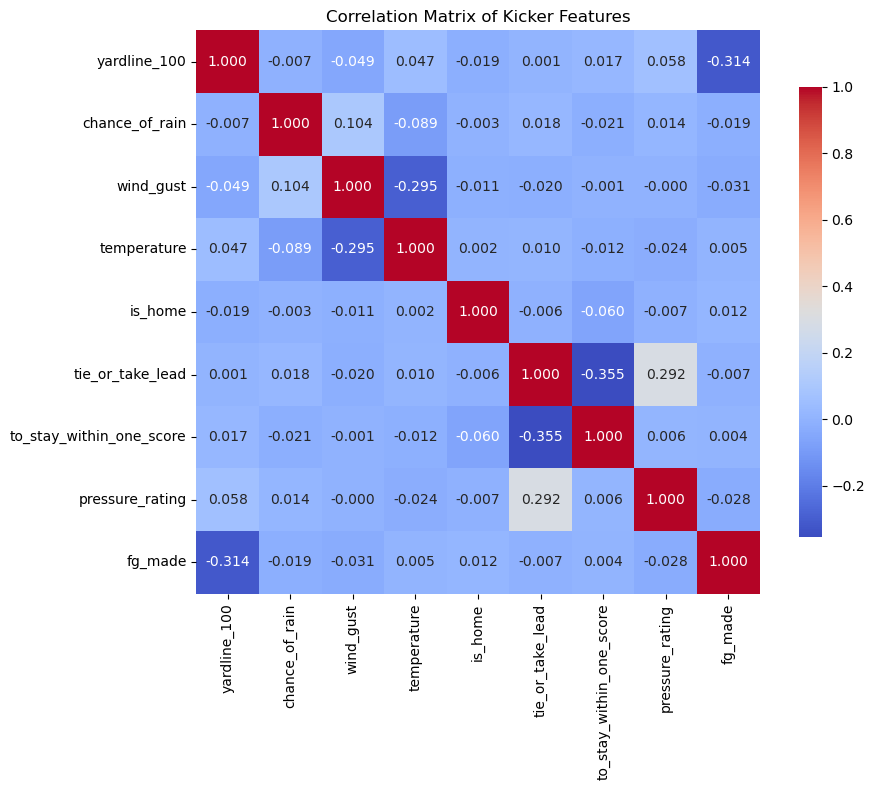

In [84]:
from matplotlib import pyplot as plt
import seaborn as sns

features = [
    'yardline_100', 
    'chance_of_rain',
    'wind_gust',  
    'temperature', 
    'is_home',
    'tie_or_take_lead',
    'to_stay_within_one_score',
    'pressure_rating',
]
kicks = (
    model_df.query('field_goal_attempt==1')
    [features + ['fg_made']]
    .copy()
)

# correlation matrix
corr_matrix = kicks.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Kicker Features')
plt.tight_layout()
plt.show()

In [97]:
# Selection Model (Probit)
selection_vars = ['yardline_100', 'ydstogo', 'game_seconds_remaining', 
                  'score_differential', 'snow_severity', 'wind_gust',
                  'temperature',
                  'tie_or_take_lead', 'to_stay_within_one_score',
                  'pressure_rating']

X_selection = sm.add_constant(model_df[selection_vars])
probit_model = sm.Probit(model_df['field_goal_attempt'], X_selection).fit(disp=0)
model_df['probit_fitted'] = probit_model.predict(X_selection)
print(probit_model.summary())

# Compute Inverse Mills Ratio (IMR)
phi = norm.pdf(probit_model.fittedvalues)
Phi = norm.cdf(probit_model.fittedvalues)
model_df['IMR'] = phi / Phi

# Outcome Model (FG make probability on subset of FG attempt plays)
outcome_vars = ['yardline_100', 
                'chance_of_rain',
                'wind_gust', 
                # 'temperature', 
                # 'is_home',
                # 'tie_or_take_lead',
                # 'to_stay_within_one_score',
                # 'pressure_rating',
                'IMR'
]
fg_attempts_df = model_df.query('field_goal_attempt==1')[outcome_vars + ['fg_made']]
X_outcome = sm.add_constant(fg_attempts_df[outcome_vars])
outcome_model = sm.Logit(fg_attempts_df['fg_made'], X_outcome).fit(disp=0)
fg_attempts_df['outcome_fitted'] = outcome_model.predict(X_outcome)
print(outcome_model.summary())

                          Probit Regression Results                           
Dep. Variable:     field_goal_attempt   No. Observations:                62669
Model:                         Probit   Df Residuals:                    62658
Method:                           MLE   Df Model:                           10
Date:                Fri, 25 Jul 2025   Pseudo R-squ.:                  0.5585
Time:                        22:22:27   Log-Likelihood:                -14958.
converged:                       True   LL-Null:                       -33877.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.7918      0.045     17.478      0.000       0.703       0.881
yardline_100                -0.0716      0.001   -124.316      0.000      -0.073      -0.